### CONDA ENVIRONMENTS

For steps __1. preprocess__ and __2. mip__, `conda activate g5ht-pipeline`

For step __3. segment__, `conda activate segment-torch` or `conda activate torchcu129`

For step __4. spline, 5. orient, 6. warp, 7. reg__

## TODO:

1. flip worms so that VNC is always up
2. fixed mask could be automated, but if not, make sure to save which index is fixed

In [1]:
import sys
import os
import importlib
from tqdm import tqdm

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

# SPECIFY DATA TO PROCESS

In [2]:
# DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\fluorescent_beads_ch_align\20251219'
DATA_PTH = r'D:\DATA\g5ht-free\20251223'

INPUT_ND2 = 'date-20251223_strain-ISg5HT_condition-starvedpatch_worm005.nd2'
# INPUT_ND2 = 'date-20251223_strain-ISg5HT_condition-starvedpatch_worm005_chan_alignment.nd2'

INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)

NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_042925.tif'

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 41

if not is_torch_env:
    noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
    num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
    beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
else:
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

print(INPUT_ND2)
print('Num z-slices: ', STACK_LENGTH)
if not is_torch_env:
    print('Number of frames: ', num_frames)
    print('Height: ', height)
    print('width: ', width)
    print('Number of channels: ', num_channels)
    print('Beads alignment file: ', beads_alignment_file)

date-20251223_strain-ISg5HT_condition-starvedpatch_worm005.nd2
Num z-slices:  41
Number of frames:  1200
Height:  512
width:  512
Number of channels:  2
Beads alignment file:  D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005_chan_alignment.nd2


# 0. PROCESS BEADS ALIGNMENT DATA (OPTIONAL, CHANGING THIS SO BEADS ARE PROCESSED SEAMLESSLY IN PIPELINE)

` conda activate g5ht-pipeline`

The registration parameters between green and red channels will be applied to worm recordings

### SHEAR CORRECT AND CHANNEL REGISTER

In [ ]:
from preprocess_parallel import main as preprocess_nd2_parallel
_ = importlib.reload(sys.modules['preprocess_parallel'])

num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 

# # command-line arguments
sys.argv = ["", beads_alignment_file, "0", str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, 5, num_frames_beads, height, width, num_channels]

# # Call the main function
preprocess_nd2_parallel()

### MIP

This step saved the median channel registration parameters, need to do this somewhere else

In [ ]:
from mip import main as mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
sys.argv = ["", beads_alignment_file, STACK_LENGTH, num_frames_beads, 2]

# Call the main function
mip()

# 1. SHEAR CORRECTION

` conda activate g5ht-pipeline`

- shear corrects each volume
  - depending on each exposure time, it can take roughly half a second between the first and last frames of a volume, so any movements need to be corrected for
- creates one `.tif` for each volume and stores it in the `shear_corrected` directory

##### TODO: should probably update stack length after shear correction since we cut it by 2, although not sure it's explicitly needed

In [ ]:
import shear_correct
_ = importlib.reload(sys.modules['shear_correct'])

start_index = "0"
cpu_count = str(int(os.cpu_count() / 2))

# sys.argv = ["", nd2 file, start_frame, end_frame, noise_pth, stack_length, n_workers, num_frames, height, width, num_channels]
sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels]

# Call the main function
shear_correct.main()

# 2. CHANNEL ALIGNMENT

` conda activate g5ht-pipeline`

### 2a. GET MEDIAN CHANNEL ALIGNMENT PARAMETERS FROM ALL FRAMES

- If channel alignment file found, uses that, if not uses worm recording
- creates a `.txt` file for each volume that contains elastix channel registration parameters
- creates `chan_align_params.csv` and  `chan_align.txt`

In [ ]:
beads_alignment_file

In [ ]:
import get_channel_alignment
import median_channel_alignment
_ = importlib.reload(sys.modules['get_channel_alignment'])
_ = importlib.reload(sys.modules['median_channel_alignment'])

## set beads_alignment_file to None to use worm recording for channel alignment, even if beads file exists
# beads_alignment_file = None

start_index = "0"
cpu_count = str(int(os.cpu_count() / 2))

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", beads_alignment_file, start_index, str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames_beads, height, width, num_channels, align_with_beads]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]

# # Call the main function
get_channel_alignment.main()
median_channel_alignment.main()


### 2b. APPLY MEDIAN CHANNEL ALIGNMENT PARAMETERS

- ouputs aligned volumes in `channel_aligned` directory

In [ ]:
import apply_channel_alignment
_ = importlib.reload(sys.modules['apply_channel_alignment'])

start_index = "0800"
cpu_count = str(int(os.cpu_count() / 2))

# 0786 to 0799 are bad frames in worm005.nd2, copied 0785 for each of those frames

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads, beads_alignment_file]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]


# Call the main function
apply_channel_alignment.main()

In [ ]:
# # create copies of 0785 and rename it to 0786 to 0799
# import shutil
# for i in range(786, 800):
#     shutil.copyfile(r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\0785.tif',
#                     r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\{:04d}.tif'.format(i))

### 2c. PLOT CHANNEL ALIGNMENT PARAMETER DISTRIBUTIONS

In [ ]:
out_dir

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# make font sizes larger for visibility
plt.rcParams.update({'font.size': 18})

out_dir = os.path.splitext(INPUT_ND2_PTH)[0]

df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

# the xaxis limits for each subplot should be the same across figures

xlims = np.zeros((6,2))

plt.figure(figsize=(12,8), tight_layout=True)
for i,param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.hist(df[param], bins=30, color='red', alpha=0.6)
    # plot the median value as a vertical line
    median_value = df[param].median()
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    # get xaxis limits
    xlims[i,:] = plt.xlim()
    # title is median value
    plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
plt.show()

out_dir = os.path.splitext(INPUT_ND2_PTH)[0] + '_chan_alignment'
df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

plt.figure(figsize=(12,8), tight_layout=True)
for i,param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.hist(df[param], bins=30, color='blue', alpha=0.6)
    # plot the median value as a vertical line
    median_value = df[param].median()
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    # apply xlims
    # plt.xlim(xlims[i,0], xlims[i,1])
    # title is median value, font size 14
    plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
plt.show()

In [ ]:
df.head()

# MIP

` conda activate g5ht-pipeline`

- outputs `focus.png`, `mip.tif`, and `mip.mp4`

##### TODO: 
- legend for focus.png, should be frame#
- mip for xy, xz, zy
- mip for several slices

In [ ]:
import mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
framerate = 10
tif_dir = 'channel_aligned' # one of 'shear_corrected' 'channel_aligned'
# tif_dir = 'channel_aligned_beads'
rmax = 750
gmax = 100
mp4_quality = 5
sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames, framerate, rmax, gmax, mp4_quality]

# Call the main function
mip.main()

# 3. SEGMENT

- outputs `label.tif`, contains segmented MIP for each volume

### on home pc
`conda activate segment-torch`

Uses a separate conda environment from the rest of the pipeline. create it using:
`conda env create -f segment_torch.yml`

### on lab pc
`conda activate torchcu129`

Uses a separate conda environment from the rest of the pipeline. create it following steps in:
`segment_torch_cu129_environment.yml`

### setup each time model weights change
Need to set path to model weights as `CHECKPOINT` in `eval_torch.py`

In [ ]:
import segment.segment_torch
_ = importlib.reload(sys.modules['segment.segment_torch'])

MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'mip_channel_aligned.tif')

# command-line arguments
sys.argv = ["", MIP_PTH]

segment.segment_torch.main()

# 4. SPLINE

`conda activate g5ht-pipeline`

- outputs `spline.json`, `spline.tif`, and `dilated.tif`

In [ ]:
import spline
_ = importlib.reload(sys.modules['spline'])

LABEL_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'label.tif')

# command-line arguments
sys.argv = ["", LABEL_PTH]

spline.main()

# 5. ORIENT

`conda activate g5ht-pipeline`

- outputs `oriented.json`, `oriented.png`, `oriented_stack.tif`

NOTE: `orient_v2.py` automated the process of finding orientation completely, whereas `orient.py` requires you to input the (x,y) nose location on the first frame

In [ ]:
import orient_v2
_ = importlib.reload(sys.modules['orient_v2'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')

# command-line arguments
sys.argv = ["", SPLINE_PTH]

orient_v2.main()

In [ ]:
import orient
_ = importlib.reload(sys.modules['orient'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')
nose_y = 210
nose_x = 9

# command-line arguments
sys.argv = ["", SPLINE_PTH, str(nose_y), str(nose_x)]

orient.main()

# 6. WARP

`conda activate g5ht-pipeline`

- ouputs: `warped/*.tif` and `masks/*.tif`

TODO: parallelize

In [5]:
import warp
_ = importlib.reload(sys.modules['warp'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 825
end_index = num_frames

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i]

    warp.main()

100%|██████████| 375/375 [43:49<00:00,  7.01s/it]


## 7. REGISTER

`conda activate g5ht-pipeline`

__ALTERNATIVELY__: register using the wholistic registration algorithm, currently in MATLAB

TODO: parallelize / make faster

In [7]:
os.path.splitext(INPUT_ND2_PTH)[0]

'D:\\DATA\\g5ht-free\\20251223\\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'

In [9]:
import reg
_ = importlib.reload(sys.modules['reg'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 0
end_index = num_frames
zoom = "1" # albert was using 3

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i, zoom]
    reg.main()

  1%|▏         | 17/1200 [08:52<10:18:03, 31.35s/it]


KeyboardInterrupt: 

### REGISTER WITH GFP+1 TO RFP

TRIM LAST RFP ZSLICE, TRIM FIRST GFP ZSLICE

seems to be that as of 20251204, all recordings were taken such that the i zslice in red channel corresponds to i+1 zslice in green channel

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg_gfp_indexing import main as reg_worm

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### MAKE MOVIES OF REGISTERED DATA (see `reg_microfilm.ipynb`)

# 8. EXPORT DATA FOR ROI LABELING

`conda activate g5ht-pipeline`

- after this step, use `lbl` conda env to label ROI of fixed frame
  - run `labelme` in terminal


maybe also see here for video annotation: https://github.com/wkentaro/labelme/tree/main/examples/video_annotation

In [ ]:
# code that exports each z-slice of fixed.tif as a separate png
import tifffile
import os
import glob

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

# in PTH directory, find a fixed_*.tif file, there is only one
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)

# fixed_pth = os.path.join(PTH, 'fixed.tif')
fixed_stack = tifffile.imread(fixed_pth)

out_dir = os.path.join(PTH, 'fixed_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[0]):
    slice_pth = os.path.join(out_dir, f'fixed_z{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[i,1,:,:]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img) 

# 9. QUANTIFY

`conda activate g5ht-pipeline`

Have to first label dorsal and ventral nerve rings and pharynx. See ...

In [ ]:
import sys
import os
import quantify
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify'])

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_not_aligned'


sys.argv = ["", PTH]
quantify.main()

#### EDIT PLOT

In [ ]:
roi_intensity = genfromtxt(os.path.join(PTH,'quantified.csv'), delimiter=',')
roi_intensity = roi_intensity[1:,:]
roi_intensity

In [ ]:
%matplotlib qt

t = roi_intensity[:,0]

plt.figure(figsize=(10, 4))
plt.plot(t, roi_intensity[:, 1] / np.mean(roi_intensity[:60, 1]), label='Dorsal nerve ring', lw=3)
plt.plot(t, roi_intensity[:, 2] / np.mean(roi_intensity[:60, 2]), label='Ventral nerve ring', lw=3)
plt.plot(t, roi_intensity[:, 3] / np.mean(roi_intensity[:60, 3]), label='Pharynx', lw=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('Time (min)')
plt.ylabel(r'$F/F_{baseline}$')
plt.xlim(t[0],t[-1])
plt.axhline(1, ls='--', c='k', zorder=0)
plt.tight_layout()
plt.show()


# QUANTIFY VOXELS

In [32]:
import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])

PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'


sys.argv = ["", PTH]
quantify_voxels.main()

Processing stacks: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Processed data shape: (651, 39, 50, 125)
Binning factor: 4
Saved normalized data to D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\normalized_voxels.npy


In [41]:
# load normalized_voxels.npy, also been binned
g5 = np.load(os.path.join(PTH, 'normalized_voxels.npy'))

# load mask, bin
# find the fixed_mask_*.tif file in PTH directory
fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask_*.tif'))[0]
mask = tifffile.imread(fixed_mask_fn)
binning_factor = 4
h, w = mask.shape
h_binned = h // binning_factor
w_binned = w // binning_factor
# binning of mask
mask_binned = mask.reshape(h_binned, binning_factor, w_binned, binning_factor).max(axis=(1,3))
# shrink the mask slightly using erosion skimage
mask_binned = erosion(mask_binned, disk(2))

# zero out values outside the mask
g5_masked = g5 * mask_binned[np.newaxis,np.newaxis,:,:]



In [5]:
g5.shape

(401, 39, 40, 100)

In [6]:
mask_binned.shape

(40, 100)

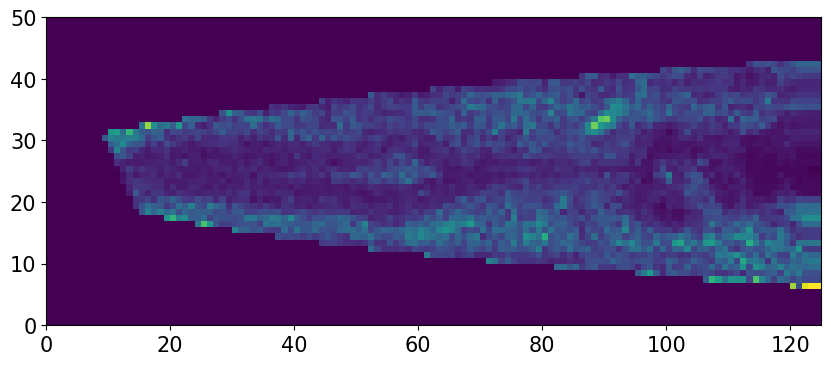

In [54]:
plt.figure(figsize=(10, 4))
plt.pcolor(g5_masked[0,25,:,:])
plt.show()

In [43]:
# now g5_masked is the 3D array of the masked, normalized G5HT signal, which can be used for downstream analysis
# let's first just plot a heatmap where each (x,y,z) voxel is on the y axis and time on the x axis. also plot the mean signal across all voxels as a line plot on top of the heatmap. this will show us how the overall signal changes over time, as well as if there are specific voxels that have different dynamics than the average.
g5_voxels = g5_masked.reshape(g5_masked.shape[0], -1)
mean_signal = g5_voxels.mean(axis=1)

In [46]:
# find the 1000 voxels with the highest mean signal across time, and are within the mask
# the mask needs to be flattened and account for it only being 1 z slice, so we can tile the mask for each z slice
nvox = 1000
mean_signal_voxels = g5_voxels.mean(axis=0)
tiled_mask = np.tile(mask_binned.flatten(), g5_voxels.shape[1] // mask_binned.size)
mean_signal_voxels_masked = mean_signal_voxels * (tiled_mask > 0)
top_voxel_indices = np.argsort(mean_signal_voxels_masked)[-nvox:]
voxels_2_plot = g5_voxels[:, top_voxel_indices]
# smooth the voxel traces with a gaussian filter, and then z-score each voxel across time
from scipy.ndimage import gaussian_filter1d
voxels_2_plot_smooth = gaussian_filter1d(voxels_2_plot, sigma=1, axis=0)
voxels_2_plot_smooth_zscore = (voxels_2_plot_smooth - voxels_2_plot_smooth.mean(axis=0)) / (voxels_2_plot_smooth.std(axis=0) + 1e-6)


toplot = voxels_2_plot_smooth_zscore

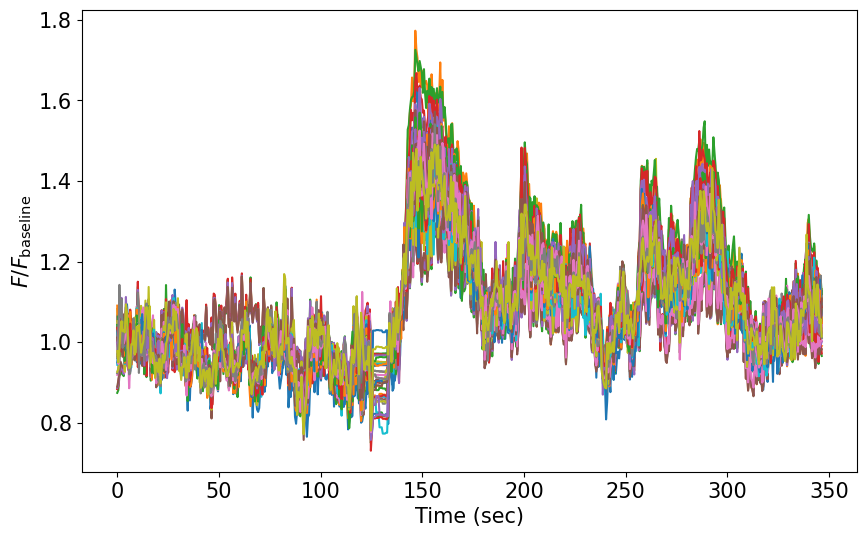

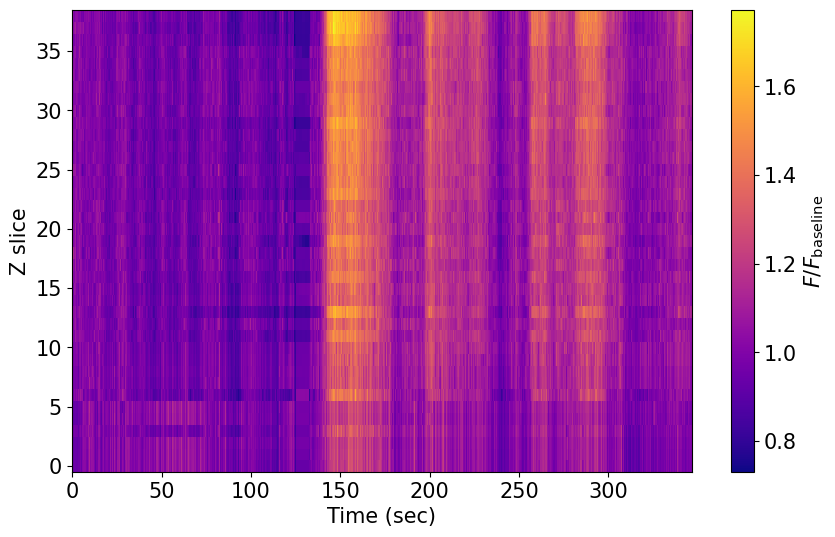

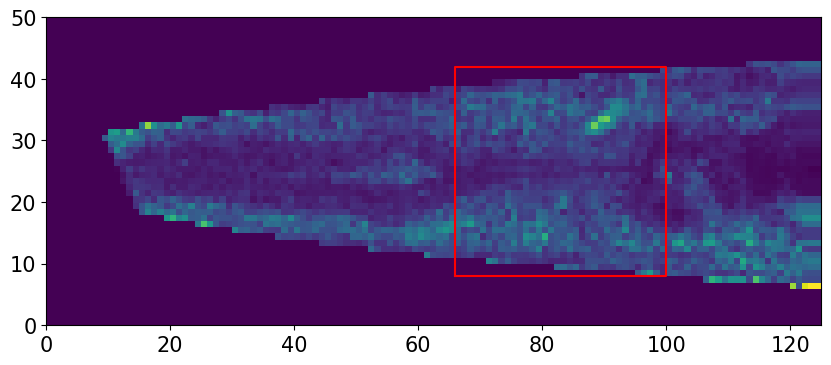

In [74]:
# get the intensity over time of the voxels in the middle of the (x,y) plane, definding a box, and all z slices
middle_x = int(g5_masked.shape[3] // 1.5)
middle_y = int(g5_masked.shape[2] // 1.95)
box_size = 17  # Define the size of the box around the middle point
middle_voxels = g5_masked[:, :, middle_y-box_size:middle_y+box_size, middle_x-box_size:middle_x+box_size].mean(axis=(2,3))
# divide each z slice by the mean activity in the first 60 time points to get F/F0
middle_voxels = middle_voxels / (middle_voxels[:60,:].mean(axis=0) + 1e-6)

plt.figure(figsize=(10, 6))
plt.plot(t, middle_voxels)
plt.xlabel('Time (sec)')
plt.ylabel('$F/F_{\\mathrm{baseline}}$')
plt.show()
# plot same thing as heatmap and sort by mean signal across time for each z slice
sorted_indices = np.argsort(middle_voxels.mean(axis=0))
middle_voxels_sorted = middle_voxels[:, sorted_indices]
plt.figure(figsize=(10, 6))
plt.pcolor(t, np.arange(middle_voxels.shape[1]), middle_voxels_sorted.T, cmap='plasma')
plt.colorbar(label='$F/F_{\\mathrm{baseline}}$')
plt.xlabel('Time (sec)')
plt.ylabel('Z slice')
plt.show()

# plot g5_masked and the box defined by box_size and middle_x, middle_y to confirm that the box is in the middle of the (x,y) plane and covers the expected area
plt.figure(figsize=(10, 4))
plt.pcolor(g5_masked[0,25,:,:])
plt.plot([middle_x-box_size, middle_x+box_size, middle_x+box_size, middle_x-box_size, middle_x-box_size],
         [middle_y-box_size, middle_y-box_size, middle_y+box_size, middle_y+box_size, middle_y-box_size], color='red')
plt.show()

# SPATIOTEMPORAL CLUSTERING OF VOXELS

Find clusters of voxels that are correlated in both space and time using:
1. Filter voxels within the mask with sufficient signal
2. Apply agglomerative clustering with spatial connectivity constraints
3. Visualize cluster locations and their mean intensity over time

In [76]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for clustering
N_CLUSTERS = 8  # number of clusters to find
MIN_SIGNAL_THRESHOLD = 0.1  # minimum mean signal to include voxel
TEMPORAL_SMOOTHING_SIGMA = 2  # gaussian smoothing for time series

# Get dimensions
n_frames, n_z, n_y, n_x = g5_masked.shape

# Create coordinate grids for spatial information
z_coords, y_coords, x_coords = np.meshgrid(
    np.arange(n_z), 
    np.arange(n_y), 
    np.arange(n_x), 
    indexing='ij'
)

# Flatten everything
voxel_timeseries = g5_masked.reshape(n_frames, -1).T  # shape: (n_voxels, n_frames)
z_flat = z_coords.flatten()
y_flat = y_coords.flatten()
x_flat = x_coords.flatten()

# Filter voxels: must be in mask and have sufficient signal
mask_3d = np.tile(mask_binned[np.newaxis, :, :], (n_z, 1, 1))
mask_flat = mask_3d.flatten()
mean_signal = voxel_timeseries.mean(axis=1)

valid_voxels = (mask_flat > 0) & (mean_signal > MIN_SIGNAL_THRESHOLD)
print(f"Total voxels: {len(valid_voxels)}")
print(f"Valid voxels (in mask with signal): {valid_voxels.sum()}")

Total voxels: 243750
Valid voxels (in mask with signal): 100677


In [77]:
# Extract valid voxel data
valid_timeseries = voxel_timeseries[valid_voxels]  # shape: (n_valid, n_frames)
valid_z = z_flat[valid_voxels]
valid_y = y_flat[valid_voxels]
valid_x = x_flat[valid_voxels]

# Smooth the time series
valid_timeseries_smooth = gaussian_filter1d(valid_timeseries, sigma=TEMPORAL_SMOOTHING_SIGMA, axis=1)

# Z-score normalize each voxel's time series for correlation-based clustering
scaler = StandardScaler()
valid_timeseries_norm = scaler.fit_transform(valid_timeseries_smooth.T).T

# Combine temporal features with spatial coordinates for clustering
# Weight spatial coordinates to encourage spatial contiguity
SPATIAL_WEIGHT = 0.5  # adjust to balance temporal vs spatial similarity

# Normalize spatial coordinates
spatial_coords = np.column_stack([valid_z, valid_y, valid_x])
spatial_coords_norm = (spatial_coords - spatial_coords.mean(axis=0)) / (spatial_coords.std(axis=0) + 1e-6)

# Create combined feature matrix: temporal + weighted spatial
combined_features = np.hstack([
    valid_timeseries_norm, 
    spatial_coords_norm * SPATIAL_WEIGHT * np.sqrt(n_frames)  # scale spatial to match temporal dimensions
])

print(f"Feature matrix shape: {combined_features.shape}")
print(f"  - Temporal features: {valid_timeseries_norm.shape[1]}")
print(f"  - Spatial features: 3 (z, y, x)")

Feature matrix shape: (100677, 654)
  - Temporal features: 651
  - Spatial features: 3 (z, y, x)


In [ ]:
# Perform agglomerative clustering
print(f"Clustering {valid_voxels.sum()} voxels into {N_CLUSTERS} clusters...")

clustering = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    metric='euclidean',
    linkage='ward'
)

cluster_labels = clustering.fit_predict(combined_features)
print(f"Clustering complete!")

# Count voxels per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
for c, n in zip(unique, counts):
    print(f"  Cluster {c}: {n} voxels")

Clustering 100677 voxels into 8 clusters...


In [ ]:
# Compute mean intensity over time for each cluster
cluster_means = np.zeros((n_frames, N_CLUSTERS))
cluster_std = np.zeros((n_frames, N_CLUSTERS))

for c in range(N_CLUSTERS):
    cluster_mask = cluster_labels == c
    cluster_timeseries = valid_timeseries[cluster_mask]  # original (non-normalized) values
    cluster_means[:, c] = cluster_timeseries.mean(axis=0)
    cluster_std[:, c] = cluster_timeseries.std(axis=0)

# Normalize to F/F0 (baseline is first 60 frames)
baseline = cluster_means[:60, :].mean(axis=0, keepdims=True)
cluster_means_norm = cluster_means / (baseline + 1e-6)
cluster_std_norm = cluster_std / (baseline + 1e-6)

print("Cluster mean time series computed!")

### Visualize Cluster Intensity Over Time

In [ ]:
# Plot mean intensity of each cluster over time
%matplotlib qt

# Create time vector (assuming same t as defined earlier, or create new one)
try:
    time_vec = t
except NameError:
    time_vec = np.arange(n_frames)

# Use a colormap for clusters
cmap = plt.cm.get_cmap('tab10', N_CLUSTERS)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top plot: All clusters overlaid
ax1 = axes[0]
for c in range(N_CLUSTERS):
    color = cmap(c)
    ax1.plot(time_vec, cluster_means_norm[:, c], label=f'Cluster {c}', color=color, lw=2, alpha=0.8)
ax1.axhline(1, ls='--', c='k', alpha=0.5, zorder=0)
ax1.set_ylabel(r'$F/F_{\mathrm{baseline}}$')
ax1.set_title('Mean Intensity of Each Cluster Over Time')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax1.set_xlim(time_vec[0], time_vec[-1])

# Bottom plot: Heatmap of cluster time series
ax2 = axes[1]
im = ax2.pcolormesh(time_vec, np.arange(N_CLUSTERS + 1), cluster_means_norm.T, cmap='plasma', shading='auto')
ax2.set_ylabel('Cluster')
ax2.set_xlabel('Time')
ax2.set_yticks(np.arange(N_CLUSTERS) + 0.5)
ax2.set_yticklabels([f'{c}' for c in range(N_CLUSTERS)])
plt.colorbar(im, ax=ax2, label=r'$F/F_{\mathrm{baseline}}$')
ax2.set_title('Cluster Intensity Heatmap')

plt.tight_layout()
plt.show()

### Visualize Cluster Spatial Locations

In [ ]:
# Create a 3D cluster label volume for visualization
cluster_volume = np.full((n_z, n_y, n_x), np.nan)

# Assign cluster labels to valid voxel positions
valid_indices = np.where(valid_voxels)[0]
for i, (z, y, x, label) in enumerate(zip(valid_z, valid_y, valid_x, cluster_labels)):
    cluster_volume[z, y, x] = label

# Plot 2D slices showing cluster locations at different z-levels
n_z_plots = min(6, n_z)
z_indices = np.linspace(0, n_z - 1, n_z_plots, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, z_idx in enumerate(z_indices):
    ax = axes[i]
    slice_data = cluster_volume[z_idx, :, :]
    
    # Create masked array for proper visualization
    masked_slice = np.ma.masked_invalid(slice_data)
    
    im = ax.imshow(masked_slice, cmap='tab10', vmin=0, vmax=N_CLUSTERS-1, interpolation='nearest')
    ax.set_title(f'Z-slice {z_idx}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(N_CLUSTERS))
cbar.set_label('Cluster')

plt.suptitle('Cluster Spatial Distribution Across Z-slices', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [ ]:
# 3D scatter plot of cluster locations
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Subsample if too many points for visualization
max_points = 5000
if len(valid_z) > max_points:
    subsample_idx = np.random.choice(len(valid_z), max_points, replace=False)
else:
    subsample_idx = np.arange(len(valid_z))

scatter = ax.scatter(
    valid_x[subsample_idx], 
    valid_y[subsample_idx], 
    valid_z[subsample_idx],
    c=cluster_labels[subsample_idx], 
    cmap='tab10', 
    vmin=0, 
    vmax=N_CLUSTERS-1,
    s=10, 
    alpha=0.6
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Cluster Distribution')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Cluster')
cbar.set_ticks(np.arange(N_CLUSTERS))

plt.tight_layout()
plt.show()

### Individual Cluster Plots with Spatial Location + Time Series

In [ ]:
# Create individual plots for each cluster showing spatial location and time series
n_cols = 4
n_rows = int(np.ceil(N_CLUSTERS / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Get MIP of one frame for background
background = g5_masked[0].max(axis=0)  # MIP across z

for c in range(N_CLUSTERS):
    ax = axes[c]
    color = cmap(c)
    
    # Create binary mask for this cluster (MIP across z)
    cluster_mask_3d = cluster_volume == c
    cluster_mask_mip = np.nanmax(cluster_mask_3d.astype(float), axis=0)
    cluster_mask_mip[cluster_mask_mip == 0] = np.nan
    
    # Plot background with cluster overlay
    ax.imshow(background, cmap='gray', alpha=0.7)
    ax.imshow(cluster_mask_mip, cmap='tab10', vmin=0, vmax=N_CLUSTERS-1, alpha=0.6)
    ax.set_title(f'Cluster {c} ({(cluster_labels == c).sum()} voxels)', color=color, fontweight='bold')
    ax.axis('off')

# Hide unused subplots
for i in range(N_CLUSTERS, len(axes)):
    axes[i].axis('off')

plt.suptitle('Cluster Spatial Locations (MIP)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot individual time series for each cluster
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for c in range(N_CLUSTERS):
    ax = axes[c]
    color = cmap(c)
    
    # Plot mean with shaded std
    mean_trace = cluster_means_norm[:, c]
    std_trace = cluster_std_norm[:, c]
    
    ax.fill_between(time_vec, mean_trace - std_trace, mean_trace + std_trace, 
                    color=color, alpha=0.3)
    ax.plot(time_vec, mean_trace, color=color, lw=2)
    ax.axhline(1, ls='--', c='k', alpha=0.3)
    ax.set_title(f'Cluster {c}', color=color, fontweight='bold')
    ax.set_xlim(time_vec[0], time_vec[-1])

# Add common labels
for ax in axes[-n_cols:]:
    ax.set_xlabel('Time')
for ax in axes[::n_cols]:
    ax.set_ylabel(r'$F/F_{\mathrm{baseline}}$')

# Hide unused subplots
for i in range(N_CLUSTERS, len(axes)):
    axes[i].axis('off')

plt.suptitle('Cluster Mean Intensity Over Time (±1 std)', fontsize=14)
plt.tight_layout()
plt.show()

### Cluster Correlation Matrix

In [ ]:
# Compute and plot correlation matrix between clusters
cluster_corr = np.corrcoef(cluster_means_norm.T)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cluster_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(N_CLUSTERS))
ax.set_xticklabels([f'{c}' for c in range(N_CLUSTERS)])
ax.set_yticklabels([f'{c}' for c in range(N_CLUSTERS)])
ax.set_xlabel('Cluster')
ax.set_ylabel('Cluster')
ax.set_title('Cluster-Cluster Correlation Matrix')

# Add correlation values as text
for i in range(N_CLUSTERS):
    for j in range(N_CLUSTERS):
        text_color = 'white' if abs(cluster_corr[i, j]) > 0.5 else 'black'
        ax.text(j, i, f'{cluster_corr[i, j]:.2f}', ha='center', va='center', 
                color=text_color, fontsize=9)

plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

### Save Cluster Results

In [ ]:
# Save clustering results
import tifffile

# Save cluster volume as tif
cluster_volume_save = np.nan_to_num(cluster_volume, nan=-1).astype(np.int16)
tifffile.imwrite(os.path.join(PTH, 'cluster_labels_volume.tif'), cluster_volume_save)

# Save cluster mean time series
cluster_results = {
    'cluster_means': cluster_means,
    'cluster_means_normalized': cluster_means_norm,
    'cluster_std': cluster_std,
    'n_clusters': N_CLUSTERS,
    'valid_voxel_coords': np.column_stack([valid_z, valid_y, valid_x]),
    'cluster_labels': cluster_labels,
    'time_vector': time_vec,
    'cluster_correlation': cluster_corr
}
np.save(os.path.join(PTH, 'cluster_results.npy'), cluster_results)

# Save cluster means as CSV for easy loading
import pandas as pd
df_clusters = pd.DataFrame(cluster_means_norm, columns=[f'cluster_{c}' for c in range(N_CLUSTERS)])
df_clusters.insert(0, 'time', time_vec)
df_clusters.to_csv(os.path.join(PTH, 'cluster_timeseries.csv'), index=False)

print(f"Saved clustering results to {PTH}")
print(f"  - cluster_labels_volume.tif: 3D volume with cluster labels")
print(f"  - cluster_results.npy: Full results dictionary")
print(f"  - cluster_timeseries.csv: Cluster mean time series")

# OLD PIPELINE

## 1. PREPROCESS

### PARALLEL

if processing locally, would recommend setting the 6th arg (number of workers) to something less than 10 if you want to use your computer at the same time

TODO:

- make a new step 2, that is 'align channels'
- it should first look for a beads .nd2, if not falls back to previous method
- alternatively, in the case of not aligning with beads, preprocess should do the median parameters and apply them

In [ ]:
from preprocess_parallel import main as preprocess_nd2_parallel
_ = importlib.reload(sys.modules['preprocess_parallel'])

# command-line arguments
# sys.argv = ["", INPUT_ND2_PTH, "0", str(num_frames), NOISE_PTH, STACK_LENGTH, 5]

# if not None:
#     align_with_beads = True # set to true when processing a worm recording with beads that have already been processed
# else:
#     align_with_beads = False
align_with_beads = True
# sys.argv = ["", INPUT_ND2_PTH, "1068", str(num_frames-1), NOISE_PTH, STACK_LENGTH, 5, num_frames, height, width, num_channels, align_with_beads]
sys.argv = ["", INPUT_ND2_PTH, "1090", "1094", NOISE_PTH, STACK_LENGTH, 5, num_frames, height, width, num_channels, align_with_beads]

# Call the main function
preprocess_nd2_parallel()

### SERIAL

In [ ]:
from preprocess import main as preprocess_nd2
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
# sys.argv = ["", INPUT_ND2_PTH, "0", NOISE_PTH]
sys.argv = ["", INPUT_ND2_PTH, "0", NOISE_PTH, STACK_LENGTH, num_frames, height, width, num_channels]

# Call the main function
preprocess_nd2()

## 2. MAX INTENSITY PROJECTION

In [ ]:
from mip import main as mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
sys.argv = ["", INPUT_ND2_PTH, STACK_LENGTH, num_frames, 10]

# Call the main function
mip()

## 3. SEGMENT

### on home pc
`conda activate segment-torch`

Uses a separate conda environment from the rest of the pipeline. create it using:
`conda env create -f segment_torch.yml`

### on lab pc
`conda activate torchcu129`

Uses a separate conda environment from the rest of the pipeline. create it following steps in:
`segment_torch_cu129_environment.yml`

### setup each time model weights change
Need to set path to model weights as `CHECKPOINT` in `eval_torch.py`

In [ ]:

import sys
import os

DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'
INPUT_ND2 = 'date-20251121_strain-ISg5HT_condition-fedpatch_worm002.nd2'
INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)
OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]
MIP_PTH = os.path.join(DATA_PTH, 'mip.tif')

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 15

print(INPUT_ND2)


In [ ]:
from segment.segment_torch import main as segment_mip


# command-line arguments
sys.argv = ["", MIP_PTH]

segment_mip()


## 4. SPLINE

`conda activate g5ht-pipeline`

In [ ]:
import sys
import os
from spline import main as get_spline

# PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\label.tif'
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251121\date-20251121_strain-ISg5HT_condition-fedpatch_worm002\label.tif'

# command-line arguments
sys.argv = ["", PTH]

get_spline()

## 5. ORIENT

`conda activate g5ht-pipeline`

In [ ]:
import sys
import os
from orient import main as find_orientation

# PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\spline.json'
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251121\date-20251121_strain-ISg5HT_condition-fedpatch_worm002\spline.json'

# command-line arguments
sys.argv = ["", PTH, 108, 42]

find_orientation()

## 6. WARP

`conda activate g5ht-pipeline`

TODO: parallelize

In [ ]:
import sys
import os
from warp import main as warp_worm
from tqdm import tqdm
from utils import get_range_from_nd2


DATA_PTH = r"C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\"
INPUT_ND2 = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned.nd2'
INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)
STACK_LENGTH = 41
num_frames, height, width, num_channels = get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 

# PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251121\date-20251121_strain-ISg5HT_condition-fedpatch_worm002'
PTH = os.path.join(DATA_PTH,os.path.splitext(INPUT_ND2)[0])

for i in tqdm(range(num_frames)):
    # command-line arguments
    sys.argv = ["", PTH, i]

    warp_worm()

### TEST PARALLEL (TODO)

In [ ]:
from warp_parallel import main as warp_worm_parallel

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# command-line arguments
sys.argv = ["", PTH, "0", "1199"]

# Call the main function
warp_worm_parallel()

## 7. REG

`conda activate g5ht-pipeline`

TODO: parallelize

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg import main as reg_worm


PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### REGISTER WITH GFP+1 TO RFP

TRIM LAST RFP ZSLICE, TRIM FIRST GFP ZSLICE

seems to be that as of 20251204, all recordings were taken such that the i zslice in red channel corresponds to i+1 zslice in green channel

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg_gfp_indexing import main as reg_worm

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### View fixed and move as one image (see reg_microfilm.ipynb)

## 8. QUANTIFY

`conda activate g5ht-pipeline`

Have to first label dorsal and ventral nerve rings and pharynx. See ...

In [ ]:
import sys
import os
from quantify import main as quantify_roi_intensity
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_not_aligned'


sys.argv = ["", PTH]
quantify_roi_intensity()

In [ ]:
roi_intensity = genfromtxt(os.path.join(PTH,'quantified.csv'), delimiter=',')
roi_intensity = roi_intensity[1:,:]
roi_intensity

In [ ]:
%matplotlib qt

t = roi_intensity[:,0]

plt.figure(figsize=(10, 4))
plt.plot(t, roi_intensity[:, 1] / np.mean(roi_intensity[:60, 1]), label='Dorsal nerve ring', lw=3)
plt.plot(t, roi_intensity[:, 2] / np.mean(roi_intensity[:60, 2]), label='Ventral nerve ring', lw=3)
plt.plot(t, roi_intensity[:, 3] / np.mean(roi_intensity[:60, 3]), label='Pharynx', lw=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('Time (min)')
plt.ylabel(r'$F/F_{baseline}$')
plt.xlim(t[0],t[-1])
plt.axhline(1, ls='--', c='k', zorder=0)
plt.tight_layout()
plt.show()
